In [1]:
#imports for user defined functions
import acquire as aq
import prepare as prep
import explore as ex

# Imports for arithmetic calculations and data frame manipulation
import math
import numpy as np
import pandas as pd

#Imports for statistical analysis
from scipy import stats
import statistics

#Imports for creating visualizations
import matplotlib.pyplot as plt 
import seaborn as sns

#Imports for modeling and model evaluation
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Planning

**Business Goals Goals**

- The goal of this project is to find drivers of churn at Telco and answer the question: "Why are customers churning? 
- Construct a Machine Learning classification model that can accurately predict customer churn.
- Deliver a report that a layman can read through and understand the process and steps taken to reach insights.
- Finally, make a recommendation to stakeholders.


**Initial Questions to Answer**

- Is there a service type more associated with churn than expected?
- Is a certain payment or contract type associated with higher churn?
- Do customers who churn have higher average monthly charges?
- Do monthly charges increase with tenure? How does this affect churn?


**Minimum Viable Product**
- Using exploratory analysis, find drivers of churn that can be used as features in a classification model that will predict churn at a rate greater than the baseline.


# Data Acquisition

In [2]:
#Acquire data using user defined function 
telco = aq.get_telco_data()
telco.head()

Using cached csv...


internet_service_type_id  payment_type_id  contract_type_id customer_id  \
0                         1                2                 2  0002-ORFBO   
1                         1                2                 1  0003-MKNFE   
2                         2                1                 1  0004-TLHLJ   
3                         2                1                 1  0011-IGKFF   
4                         2                2                 1  0013-EXCHZ   

   gender  senior_citizen partner dependents  tenure phone_service  ...  \
0  Female               0     Yes        Yes       9           Yes  ...   
1    Male               0      No         No       9           Yes  ...   
2    Male               0      No         No       4           Yes  ...   
3    Male               1     Yes         No      13           Yes  ...   
4  Female               1     Yes         No       3           Yes  ...   

  tech_support streaming_tv streaming_movies paperless_billing  \
0          Yes          Yes               No               Yes   
1           No           No              Yes                No   
2           No           No               No               Yes   
3           No          Yes              Yes               Yes   
4          Yes          Yes               No               Yes   

  monthly_charges total_charges churn   contract_type      payment_type  \
0            65.6         593.3    No        One year      Mailed check   
1            59.9         542.4    No  Month-to-month      Mailed check   
2            73.9        280.85   Yes  Month-to-month  Electronic check   
3            98.0       1237.85   Yes  Month-to-month  Electronic check   
4            83.9         267.4   Yes  Month-to-month      Mailed check   

  internet_service_type  
0                   DSL  
1                   DSL  
2           Fiber optic  
3           Fiber optic  
4           Fiber optic  

[5 rows x 24 columns]

In [3]:
#Initial sanity check -- internet_service_type_id, payment_type_id, contract_type_id are all duplicated
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   internet_service_type_id  7043 non-null   int64  
 1   payment_type_id           7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [4]:
telco.isnull().sum() # No nulls detected

internet_service_type_id    0
payment_type_id             0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
payment_type                0
internet_service_type       0
dtype: int64

# Data Cleaning/Prep

array([[<AxesSubplot:title={'center':'internet_service_type_id'}>,
        <AxesSubplot:title={'center':'payment_type_id'}>],
       [<AxesSubplot:title={'center':'contract_type_id'}>,
        <AxesSubplot:title={'center':'senior_citizen'}>],
       [<AxesSubplot:title={'center':'tenure'}>,
        <AxesSubplot:title={'center':'monthly_charges'}>]], dtype=object)

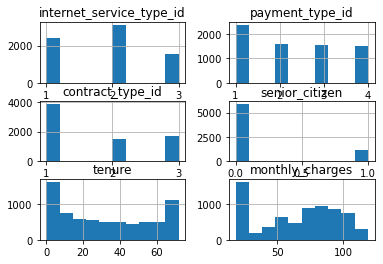

In [5]:
telco.hist()

In [6]:
#No phone service value is duplicated in phone service column
telco.multiple_lines.value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64

In [7]:
#No internet service value will be duplicated with internet_service_type column
telco.online_security.value_counts() 

# The same will go for online_backup, device_protection, tech_support, steaming_tv, and streaming_movies
# Will need to encode these to avoid the duplication

No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64

In [8]:
# Creating function for initial data cleaning and prep

def prep_telco(telco):
    #Dropping potential duplicates
    telco.drop_duplicates(inplace = True)
    
    #Removing leading and trailing spaces
    telco['total_charges'] = telco['total_charges'].str.strip()
    #Removing rows where tenure and total_charges = 0
    telco = telco[telco.total_charges != '']
    #Changing total_charges to appropriate data type
    telco['total_charges'] = telco.total_charges.astype(float)
   
    #Dropping duplicate columns
    columns_to_drop = ['contract_type_id', 'payment_type_id', 'internet_service_type_id']
    telco = telco.drop(columns = columns_to_drop)

    #Encoding binary categorical variables
    telco['partner'] = telco.partner.map({'Yes': 1, 'No': 0})
    telco['dependents'] = telco.dependents.map({'Yes': 1, 'No': 0})
    telco['phone_service'] = telco.phone_service.map({'Yes': 1, 'No': 0})
    telco['paperless_billing'] = telco.paperless_billing.map({'Yes': 1, 'No': 0})
    telco['churn'] = telco.churn.map({'Yes': 1, 'No': 0})
    
    #Encoding other columns to remove duplicates between phone service and internet service type
    to_replace ={'Yes': 1, 'No': 0, 'No phone service':0, 'No internet service': 0}
    telco = telco.replace(to_replace)
    
    
    #Creating dummy variables for necessary columns and concatenating to data frame, then dropping the extra columns
    #Leaving drop_first as False for initial clarity
    dummy_telco = pd.get_dummies(telco[['gender','contract_type', 'payment_type', 'internet_service_type']], 
                         dummy_na = False, 
                         drop_first = False)
    telco = pd.concat([telco, dummy_telco], axis = 1)
    telco = telco.drop(columns= ['gender', 'contract_type', 'payment_type', 'internet_service_type'])
    
    return telco



In [9]:
# Use function to clean data 

clean_telco = prep_telco(telco)

In [10]:
#Sanity check
clean_telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   customer_id                             7032 non-null   object 
 1   senior_citizen                          7032 non-null   int64  
 2   partner                                 7032 non-null   int64  
 3   dependents                              7032 non-null   int64  
 4   tenure                                  7032 non-null   int64  
 5   phone_service                           7032 non-null   int64  
 6   multiple_lines                          7032 non-null   int64  
 7   online_security                         7032 non-null   int64  
 8   online_backup                           7032 non-null   int64  
 9   device_protection                       7032 non-null   int64  
 10  tech_support                            7032 non-null   int6

In [11]:
clean_telco.isnull().sum()

customer_id                               0
senior_citizen                            0
partner                                   0
dependents                                0
tenure                                    0
phone_service                             0
multiple_lines                            0
online_security                           0
online_backup                             0
device_protection                         0
tech_support                              0
streaming_tv                              0
streaming_movies                          0
paperless_billing                         0
monthly_charges                           0
total_charges                             0
churn                                     0
gender_Female                             0
gender_Male                               0
contract_type_Month-to-month              0
contract_type_One year                    0
contract_type_Two year                    0
payment_type_Bank transfer (auto

In [12]:
# Renaming columns 

to_rename = {'gender_Female': 'female', 'gender_Male': 'male', 
             'contract_type_Month-to-month': 'monthly_contract',
             'contract_type_One year': 'one_yr_contract', 
             'contract_type_Two year': 'two_yr_contract', 
             'payment_type_Bank transfer (automatic)': 'auto_bank_transfer', 
             'payment_type_Credit card (automatic)': 'auto_credit_card',
             'payment_type_Electronic check': 'electronic_check',
             'payment_type_Mailed check': 'mailed_check',
             'internet_service_type_DSL': 'dsl',
             'internet_service_type_Fiber optic': 'fiber_optic',
             'internet_service_type_None': 'no_internet'}

clean_telco = clean_telco.rename(columns=to_rename)
clean_telco[(clean_telco.no_internet) == 1]

customer_id  senior_citizen  partner  dependents  tenure  phone_service  \
20    0023-UYUPN               1        1           0      50              1   
23    0030-FNXPP               0        0           0       3              1   
24    0031-PVLZI               0        1           1       4              1   
27    0040-HALCW               0        1           1      54              1   
28    0042-JVWOJ               0        0           0      26              1   
...          ...             ...      ...         ...     ...            ...   
7026  9970-QBCDA               0        0           0       6              1   
7028  9972-EWRJS               0        1           1      67              1   
7032  9975-GPKZU               0        1           1      46              1   
7033  9975-SKRNR               0        0           0       1              1   
7037  9986-BONCE               0        0           0       4              1   

      multiple_lines  online_security  online_backup  device_protection  ...  \
20                 1                0              0                  0  ...   
23                 0                0              0                  0  ...   
24                 0                0              0                  0  ...   
27                 0                0              0                  0  ...   
28                 0                0              0                  0  ...   
...              ...              ...            ...                ...  ...   
7026               0                0              0                  0  ...   
7028               0                0              0                  0  ...   
7032               0                0              0                  0  ...   
7033               0                0              0                  0  ...   
7037               0                0              0                  0  ...   

      monthly_contract  one_yr_contract  two_yr_contract  auto_bank_transfer  \
20                   0                1                0                   0   
23                   1                0                0                   0   
24                   1                0                0                   0   
27                   0                0                1                   0   
28                   0                1                0                   1   
...                ...              ...              ...                 ...   
7026                 1                0                0                   0   
7028                 0                0                1                   1   
7032                 0                0                1                   0   
7033                 1                0                0                   0   
7037                 1                0                0                   1   

      auto_credit_card  electronic_check  mailed_check  dsl  fiber_optic  \
20                   0                 1             0    0            0   
23                   0                 0             1    0            0   
24                   0                 0             1    0            0   
27                   1                 0             0    0            0   
28                   0                 0             0    0            0   
...                ...               ...           ...  ...          ...   
7026                 1                 0             0    0            0   
7028                 0                 0             0    0            0   
7032                 1                 0             0    0            0   
7033                 0                 0             1    0            0   
7037                 0                 0             0    0            0   

      no_internet  
20              1  
23              1  
24              1  
27              1  
28              1  
...           ...  
7026            1  
7028            1  
7032            1  
7033     

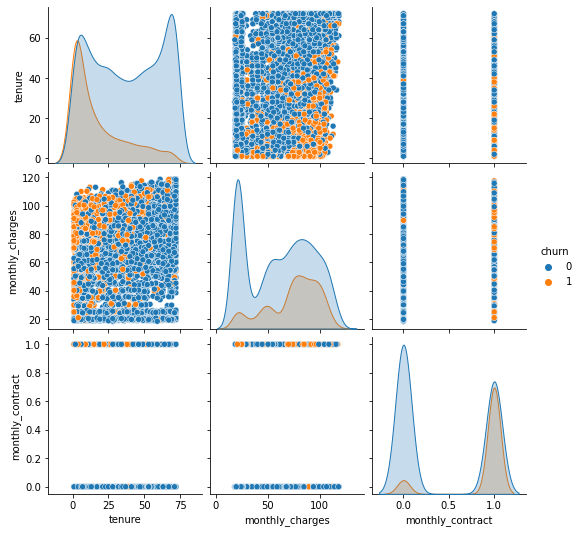

In [13]:
#Visualize relationship of churn with some variables
sns.pairplot(clean_telco[['tenure', 'monthly_charges', 'monthly_contract', 'churn']], hue='churn')

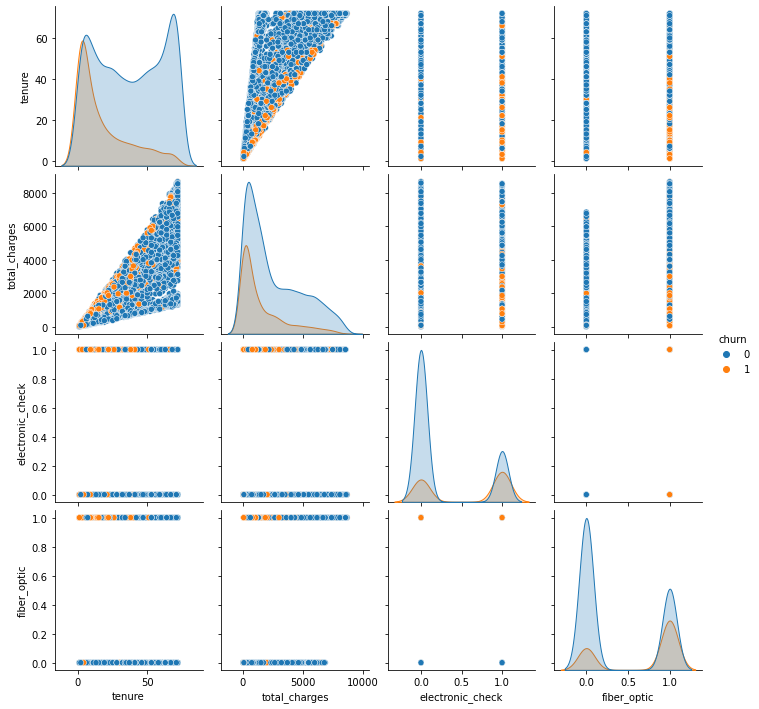

In [14]:
sns.pairplot(clean_telco[['tenure', 'total_charges', 'electronic_check', 'fiber_optic', 'churn']], hue='churn')

In [118]:
#Test my prepare.py file
df = prep.prep_telco(telco)
df.head()

customer_id  senior_citizen  partner  dependents  tenure  phone_service  \
0  0002-ORFBO               0        1           1       9              1   
1  0003-MKNFE               0        0           0       9              1   
2  0004-TLHLJ               0        0           0       4              1   
3  0011-IGKFF               1        1           0      13              1   
4  0013-EXCHZ               1        1           0       3              1   

   multiple_lines  online_security  online_backup  device_protection  ...  \
0               0                0              1                  0  ...   
1               1                0              0                  0  ...   
2               0                0              0                  1  ...   
3               0                0              1                  1  ...   
4               0                0              0                  0  ...   

   monthly_contract  one_yr_contract  two_yr_contract  auto_bank_transfer  \
0                 0                1                0                   0   
1                 1                0                0                   0   
2                 1                0                0                   0   
3                 1                0                0                   0   
4                 1                0                0                   0   

   auto_credit_card  electronic_check  mailed_check  dsl  fiber_optic  \
0                 0                 0             1    1            0   
1                 0                 0             1    1            0   
2                 0                 1             0    0            1   
3                 0                 1             0    0            1   
4                 0                 0             1    0            1   

   no_internet  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 29 columns]

In [133]:
df[df['monthly_contract'] == 1].count()

customer_id           3875
senior_citizen        3875
partner               3875
dependents            3875
tenure                3875
phone_service         3875
multiple_lines        3875
online_security       3875
online_backup         3875
device_protection     3875
tech_support          3875
streaming_tv          3875
streaming_movies      3875
paperless_billing     3875
monthly_charges       3875
total_charges         3875
churn                 3875
female                3875
male                  3875
monthly_contract      3875
one_yr_contract       3875
two_yr_contract       3875
auto_bank_transfer    3875
auto_credit_card      3875
electronic_check      3875
mailed_check          3875
dsl                   3875
fiber_optic           3875
no_internet           3875
dtype: int64

In [134]:
df.monthly_charges.mean()

64.7982081911263

# Data splitting

In [16]:
train_validate, test = train_test_split(df, test_size=.2,
                                       random_state=123,
                                       stratify=df.churn)
    
train, validate = train_test_split(train_validate, test_size=.3,
                                  random_state=123,
                                  stratify=train_validate.churn)

In [17]:
print(train.shape)
print(validate.shape)
print(test.shape)

(3937, 29)
(1688, 29)
(1407, 29)


In [18]:
# Creating x & y version of train, validate, test
X_train = train.drop(columns=['churn', 'customer_id'])
y_train = train.churn

X_validate = validate.drop(columns=['churn', 'customer_id'])
y_validate = validate.churn

X_test = test.drop(columns=['churn', 'customer_id'])
y_test = test.churn

In [19]:
#Sanity check
X_train.head()

senior_citizen  partner  dependents  tenure  phone_service  \
5919               0        0           0      58              1   
1915               0        0           1      71              1   
5054               0        1           1      35              1   
2355               0        1           1       1              1   
6279               1        0           0      20              1   

      multiple_lines  online_security  online_backup  device_protection  \
5919               1                1              1                  1   
1915               1                1              1                  0   
5054               1                0              0                  0   
2355               0                0              0                  0   
6279               0                1              0                  0   

      tech_support  ...  monthly_contract  one_yr_contract  two_yr_contract  \
5919             1  ...                 0                1                0   
1915             0  ...                 0                1                0   
5054             0  ...                 1                0                0   
2355             0  ...                 1                0                0   
6279             1  ...                 0                1                0   

      auto_bank_transfer  auto_credit_card  electronic_check  mailed_check  \
5919                   0                 1                 0             0   
1915                   0                 1                 0             0   
5054                   0                 0                 1             0   
2355                   0                 0                 0             1   
6279                   0                 0                 0             1   

      dsl  fiber_optic  no_internet  
5919    1            0            0  
1915    0            1            0  
5054    0            0            1  
2355    0            0            1  
6279    1            0            0  

[5 rows x 27 columns]

# Data Exploration

## Overview exploration of churn vs all variables ##

In [20]:
#Exploring my target -- Churn
train.churn.value_counts(normalize=True)

0    0.734315
1    0.265685
Name: churn, dtype: float64

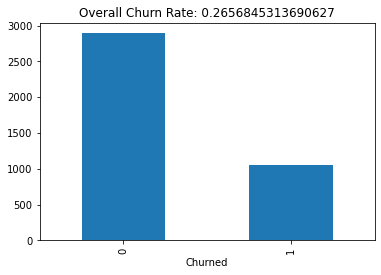

In [21]:
train.churn.value_counts().sort_index().plot.bar()
churn_rate = train.churn.mean()
plt.title(f'Overall Churn Rate: {churn_rate}')
plt.xlabel('Churned')
plt.show()

Text(0, 0.5, 'Correlation')

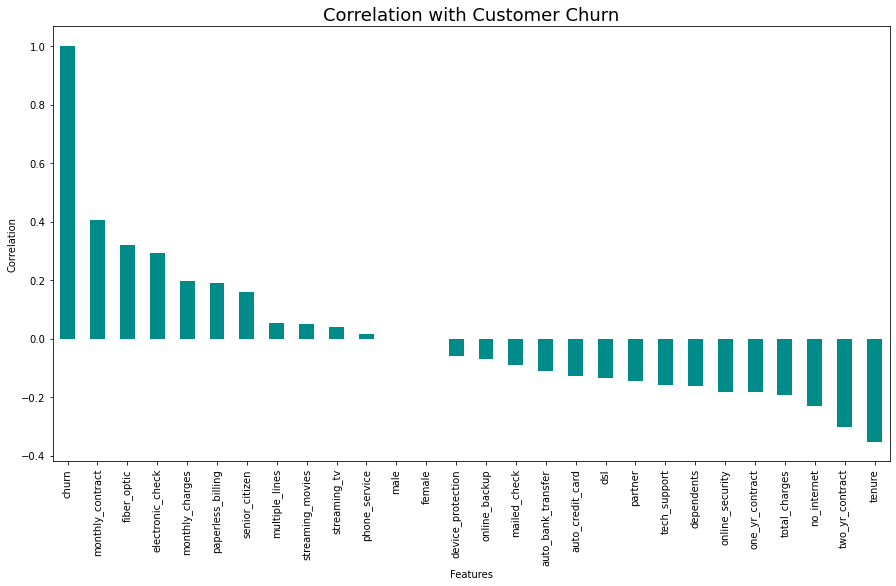

In [22]:
# Checking churn vs all variables

quant_vars = ['tenure', 'monthly_charges', 'total_charges']
cat_vars = list((train.columns).drop(quant_vars))
target = train.churn

plt.figure(figsize= (15, 8))
train.corr()['churn'].sort_values(ascending=False).plot(kind='bar', color = 'darkcyan')
plt.title('Correlation with Customer Churn', fontsize = 18)
plt.xlabel('Features')
plt.ylabel('Correlation')

Initial Takeways
- The top 5 features correlated with churn: monthly_contract, fiber_optic, electronic_check, monthly_charges, paperless_billing
- Customers with yearly contracts have negative correlations with churn. 
- Automatic payments have a negative correlation with churn in contrast to electronic_checks which are manual. 
- Gender has virtually no correlation with churn. 

## Answering my initial questions from planning stage: ##

## Is there a service type more associated with churn than expected? ##
**Internet service.**

In [23]:
train.columns

Index(['customer_id', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'female', 'male', 'monthly_contract', 'one_yr_contract',
       'two_yr_contract', 'auto_bank_transfer', 'auto_credit_card',
       'electronic_check', 'mailed_check', 'dsl', 'fiber_optic',
       'no_internet'],
      dtype='object')

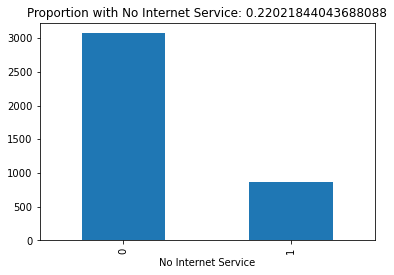

In [24]:
# Check proportion of those who have internet service overall
## For no_internet 0 indicates they have internet service and 1 indicates they do not
train.no_internet.value_counts().sort_index().plot.bar()
rate = train.no_internet.mean()
plt.title(f'Proportion with No Internet Service: {rate}')
plt.xlabel('No Internet Service')
plt.show()

*This visualization may be a bit confusing at first but the 0 is what indicates who has internet -- so about 78% of customers do have some form of internet service.*

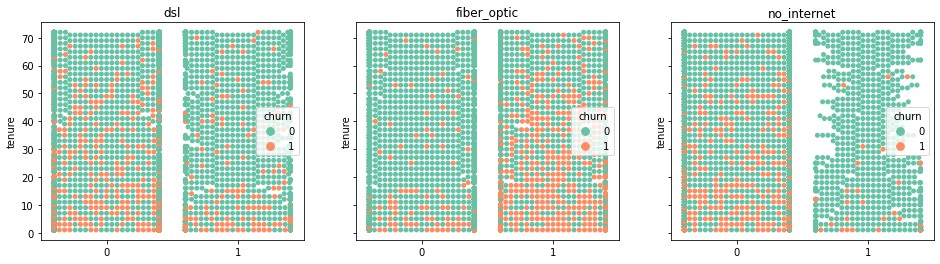

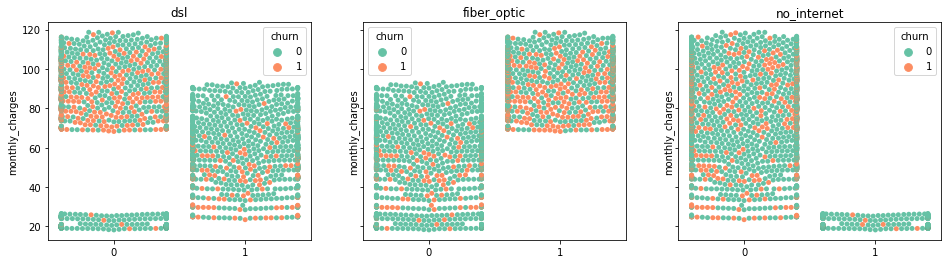

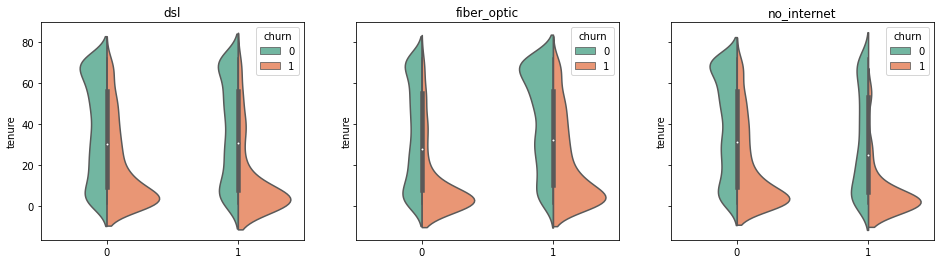

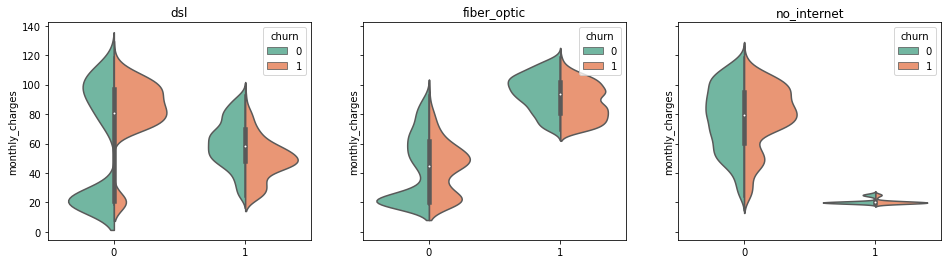

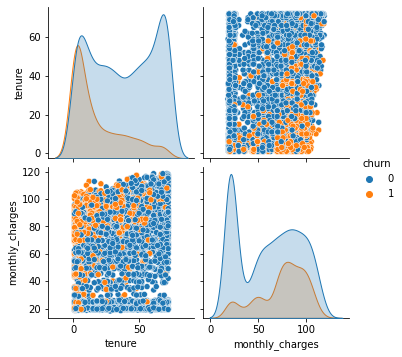

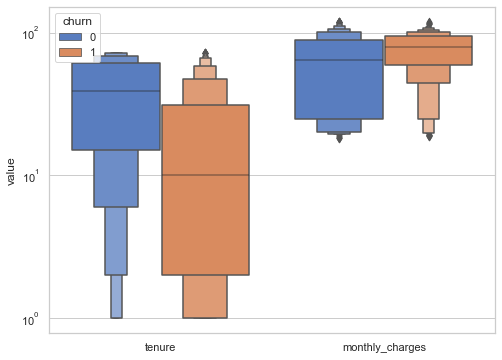

In [25]:
#Conduct multivariate statistic visualiazation
target = 'churn'
cat_vars = ['dsl', 'fiber_optic', 'no_internet']
quant_vars = ['tenure', 'monthly_charges']

ex.explore_multivariate(train, target, cat_vars, quant_vars)

Takeaways:
- Visualizations indicate a higher rate of churn for those who have internet service and particularly high churn amongst those with fiber optic internet.
- Fiber optic seems to have much higher monthly charges on average -- that said monthly charges overall doesn't seem to be a huge indicator of churn. 

In [26]:
#Chi square test on no_internet vs. churn
## For no_internet 0 indicates they have internet service and 1 indicates they do not

cat_var = 'no_internet'
target= 'churn'
alpha =.05


observed = pd.crosstab(train[cat_var], train[target])

H0: Having internet service is independent of churning.

Ha: Having internet service and churning are dependent on eachother. They are correlated.

In [27]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p

(208.5364767947143, 2.8653012180661676e-47)

In [28]:
# Outcome
if p < alpha:
    print('We reject the null hypothesis that the variables are independent of eachother. There is a correlation.')
else:
    print('We cannot reject the null hyptohesis that the variables are independent of eachother. There is no significant statistical correlation.')

We reject the null hypothesis that the variables are independent of eachother. There is a correlation.


In [29]:
#Chi Square test on fiber_optic vs Churn
cat_var = 'fiber_optic'
target= 'churn'
observed = pd.crosstab(train[cat_var], train[target])

H0: Having dsl service is independent of churning.

Ha: Having dsl service and churning are dependent on eachother. They are correlated.

In [30]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p

(405.92112170517066, 2.831419548361709e-90)

In [119]:
# Outcome
if p < alpha:
    print('We reject the null hypothesis that the variables are independent of eachother. There is a correlation.')
else:
    print('We cannot reject the null hyptohesis that the variables are independent of eachother. There is no significant statistical correlation.')

We reject the null hypothesis that the variables are independent of eachother. There is a correlation.


## Is there a service type more associated with churn than expected? ##
**Phone service**

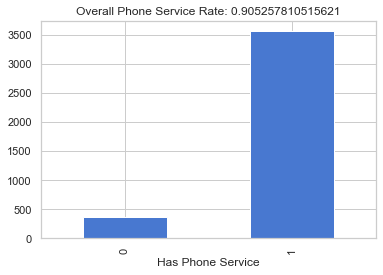

In [32]:
# Check proportion of those who have phone service overall
train.phone_service.value_counts().sort_index().plot.bar()
rate = train.phone_service.mean()
plt.title(f'Overall Phone Service Rate: {rate}')
plt.xlabel('Has Phone Service')
plt.show()

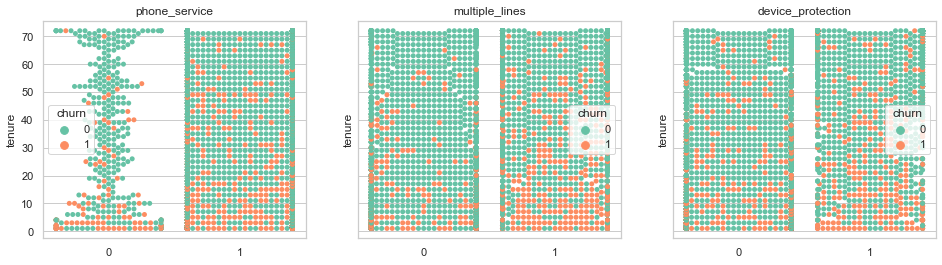

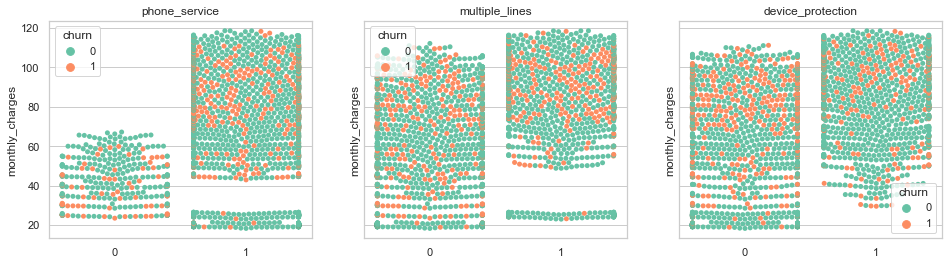

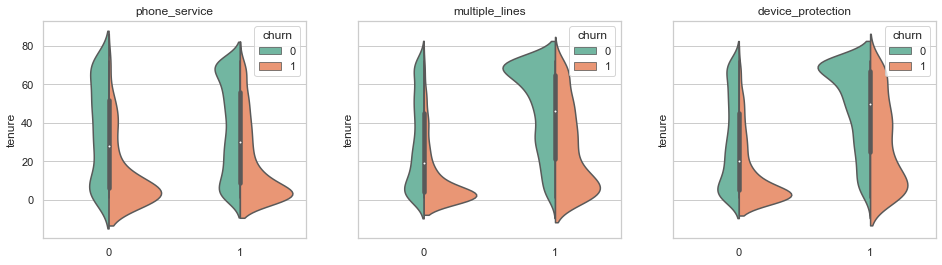

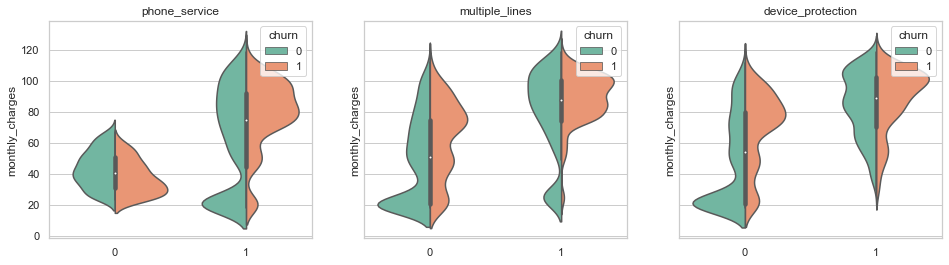

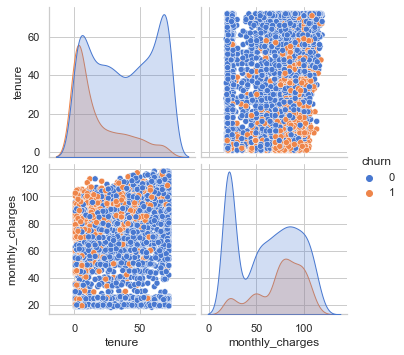

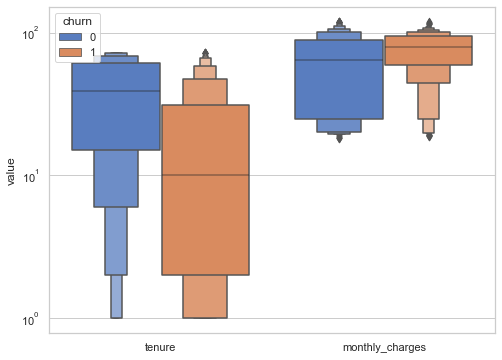

In [33]:
#Conduct multivariate statistic visualiazation
target = 'churn'
cat_vars = ['phone_service', 'multiple_lines', 'device_protection']
quant_vars = ['tenure', 'monthly_charges']

ex.explore_multivariate(train, target, cat_vars, quant_vars)

Takeaways:

- Most customers have phone service.
- Customers with phone service do churn at a slightly higher rate but since around 90% of customers have phone service this doesn't seem that significant.
- Customers with multiple lines do seem to churn at a slighly higher rate.
- Again, higher monthly charges does affect churn, which makes sense since higher monthly charges would be associated with having multiple lines or the more expensive fiber optic service. 

In [34]:
#Chi Square test on multiple_lines vs Churn
cat_var = 'multiple_lines'
target= 'churn'

observed = pd.crosstab(train[cat_var], train[target])

H0: Having multiple phone lines is independent of churning.

Ha: Having multiple phone lines and churning are dependent on eachother. They are correlated.

In [35]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p

(10.830305478664364, 0.0009985216252164028)

In [36]:
# Outcome
if p < alpha:
    print('We reject the null hypothesis that the variables are independent of eachother. There is a correlation.')
else:
    print('We cannot reject the null hyptohesis that the variables are independent of eachother. There is no significant statistical correlation.')

We reject the null hypothesis that the variables are independent of eachother. There is a correlation.


## Is a certain payment or contract type associated with higher churn? 
**Payment Type**

In [37]:
train.columns

Index(['customer_id', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'female', 'male', 'monthly_contract', 'one_yr_contract',
       'two_yr_contract', 'auto_bank_transfer', 'auto_credit_card',
       'electronic_check', 'mailed_check', 'dsl', 'fiber_optic',
       'no_internet'],
      dtype='object')

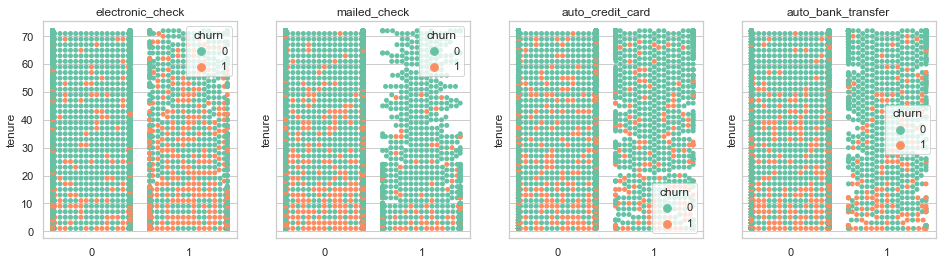

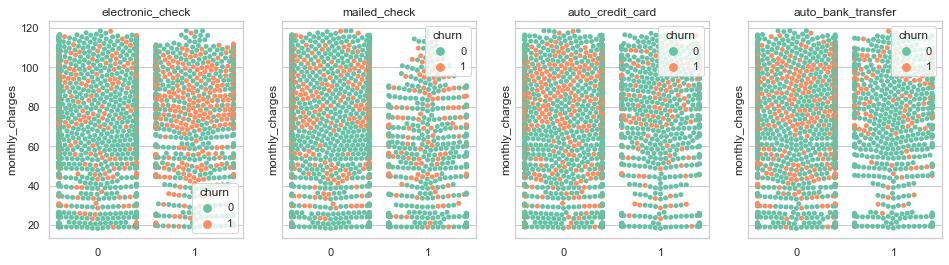

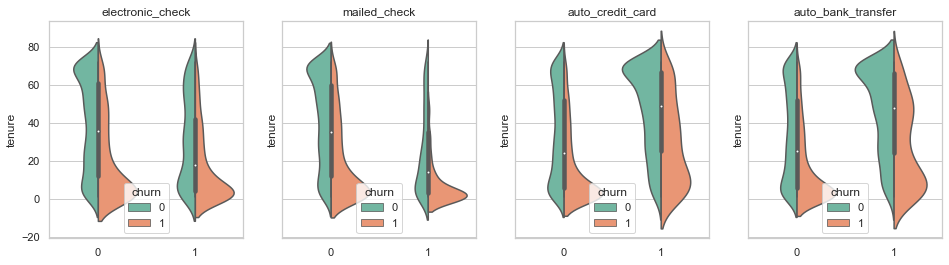

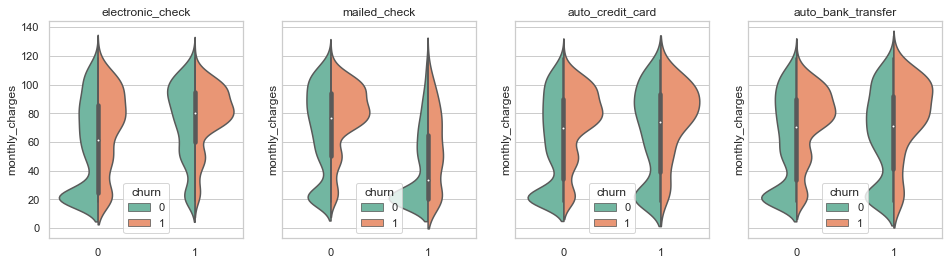

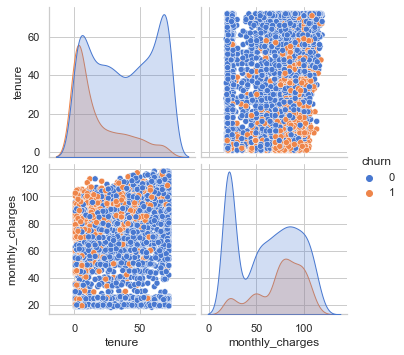

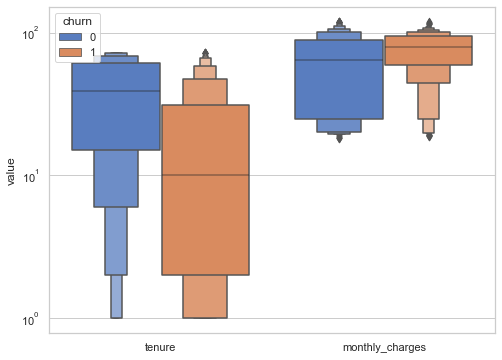

In [38]:
#Conduct multivariate statistic visualization
target = 'churn'
cat_vars = ['electronic_check', 'mailed_check', 'auto_credit_card', 'auto_bank_transfer']
quant_vars = ['tenure', 'monthly_charges']

ex.explore_multivariate(train, target, cat_vars, quant_vars)

Takeaways:
    
- Those who pay by electronic check churn at a much higher rate than other payment types. 
- Mailed checks, and the automatic payments types don't seem to be significantly correlated with churn. 

In [39]:
#Chi Square test on electronic_check vs Churn
cat_var = 'electronic_check'
target= 'churn'

observed = pd.crosstab(train[cat_var], train[target])

H0: Paying by electronic check is independent of churning.

Ha: Paying by electronic check and churning are dependent on eachother. They are correlated.

In [40]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p

(334.97978026680926, 7.910587922260644e-75)

In [41]:
# Outcome
if p < alpha:
    print('We reject the null hypothesis that the variables are independent of eachother. There is a correlation.')
else:
    print('We cannot reject the null hyptohesis that the variables are independent of eachother. There is no significant statistical correlation.')

We reject the null hypothesis that the variables are independent of eachother. There is a correlation.


## Is a certain payment or contract type associated with higher churn? 
**Contract Type**

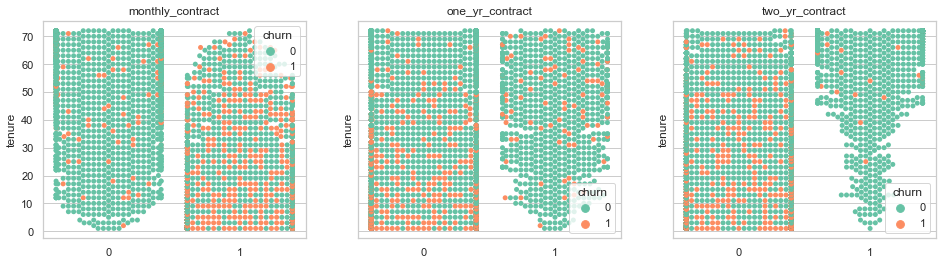

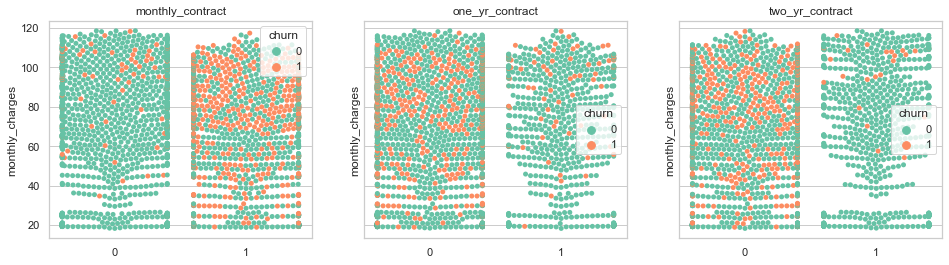

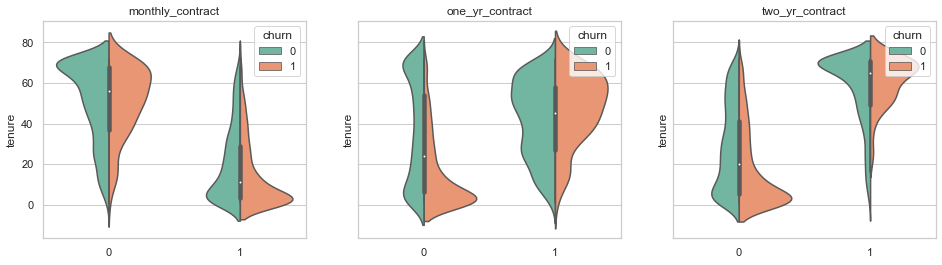

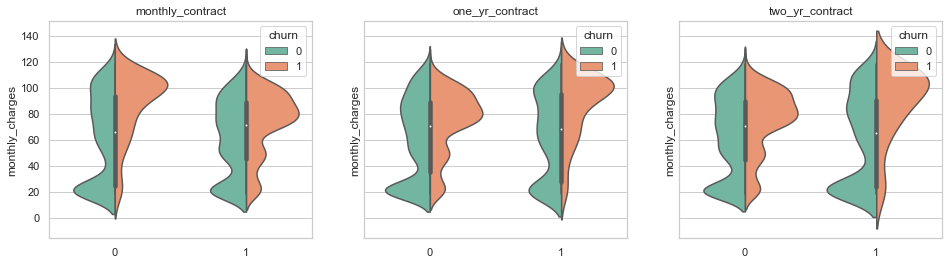

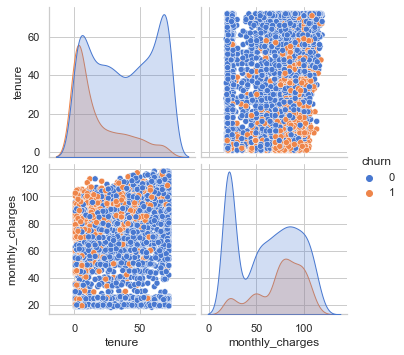

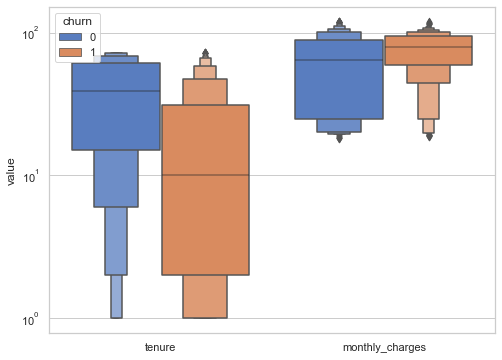

In [42]:
#Conduct multivariate statistic visualization
target = 'churn'
cat_vars = ['monthly_contract', 'one_yr_contract', 'two_yr_contract']
quant_vars = ['tenure', 'monthly_charges']

ex.explore_multivariate(train, target, cat_vars, quant_vars)

Takeaways:
- Monthly contracts have much much higher churn than yearly contracts. 

In [43]:
#Chi Square test on electronic_check vs Churn

cat_var = 'monthly_contract'
target= 'churn'

observed = pd.crosstab(train[cat_var], train[target])

H0: Having a monthly contract is independent of churning.

Ha: Having a monthly contract and churning are dependent on eachother. They are correlated.

In [44]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p

(649.1331915563476, 3.4484593947893894e-143)

In [45]:
# Outcome
if p < alpha:
    print('We reject the null hypothesis that the variables are independent of eachother. There is a correlation.')
else:
    print('We cannot reject the null hyptohesis that the variables are independent of eachother. There is no significant statistical correlation.')

We reject the null hypothesis that the variables are independent of eachother. There is a correlation.


## Do customers who churn have higher average monthly charges? ##

(Text(0.5, 1.0, 'monthly_charges'),
 count    3937.000000
 mean       64.805131
 std        30.294804
 min        18.250000
 25%        34.700000
 50%        70.250000
 75%        90.300000
 max       118.650000
 Name: monthly_charges, dtype: float64)

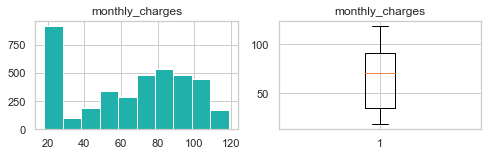

In [46]:
#Univariate exploration of monthly charges
quant_var = 'monthly_charges'
ex.explore_univariate_quant(train, quant_var)

Takeaways:
- Fairly normal distribution but with most chargest around the $20/month range.

Hypotheses
    
H0: The mean of churned customers' monthly charges is less than or equal to not churned customers.

Ha: The mean of churned customers' monthly charges mean is more than not churned customers.

In [47]:
#Subsetting data between churned and not churned
churned = train[train.churn == 1]
not_churned = train[train.churn == 0]

In [48]:
#Subsetting data to include mean of monthly charges
churn_monthly_charges = churned.monthly_charges
overall_mean = train.monthly_charges.mean()

In [49]:
# Checking variances
churned.monthly_charges.var(), not_churned.monthly_charges.var()

(604.8633241695393, 982.7932072180829)

In [50]:
# What's the overall mean?
overall_mean

64.80513081026147

In [51]:
# What's the mean of monthly_charges amongst customers who churned?
churn_monthly_charges.mean()

74.71921606118552

In [52]:
# Conduct a one sample t-test

t, p = stats.ttest_1samp(churn_monthly_charges, overall_mean)

print(t, p/2, alpha)

13.037366230308015 2.0798982128378347e-36 0.05


In [53]:
if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis.")


We reject the null hypothesis.


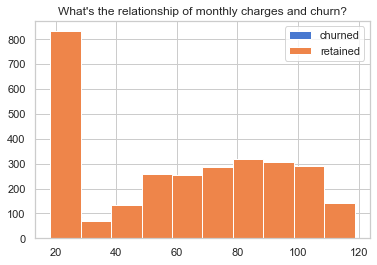

In [54]:
plt.title("What's the relationship of monthly charges and churn?")
plt.hist(churned.monthly_charges, label="churned")
plt.hist(not_churned.monthly_charges, label="retained")
plt.legend()
plt.show()

*This visualization doesn\'t show a clear distinction.*

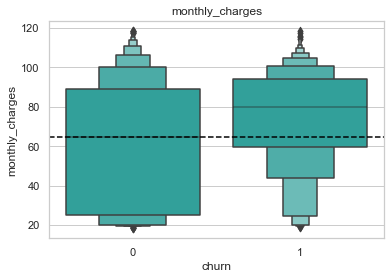

In [55]:
ex.plot_boxen(train, target, quant_var)

*This visualization clearly shows the average monthly charges and that they are higher among customers who churned.*

## Do monthly charges increase with tenure? How does this affect churn? ##

Hypothesis

H0: There is no linear correlation between monthly charges and tenure.
    
Ha: There is a linear correlation between monthly charges and tenrue.

In [56]:
# Calculating Pearson's Correlation Coefficient -- Tenure vs. Monthly Charges
x = train.tenure
y= train.monthly_charges

corr, p = stats.pearsonr(x, y)
corr, p

(0.2584558724797175, 4.133540022116172e-61)

In [57]:
# Outcome
alpha = .05
if p < alpha:
    print('We reject the null hypothesis that there is no linear correlation. There is a correlation.')
else:
    print('We cannot reject the null hyptohesis that there is no linear correlation.')

We reject the null hypothesis that there is no linear correlation. There is a correlation.


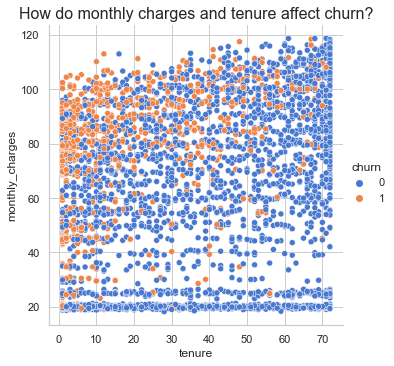

In [58]:
# Let's see how monthly charges and tenure intereact with churn
sns.relplot(x='tenure', y='monthly_charges', hue='churn', data=train)
plt.title('How do monthly charges and tenure affect churn?', fontsize= 16)
plt.show()

*I like this visualization as it clearly shows that those who churn are paying more on average and shows a general range for their tenure when they churn: most before the 1 yr mark.*

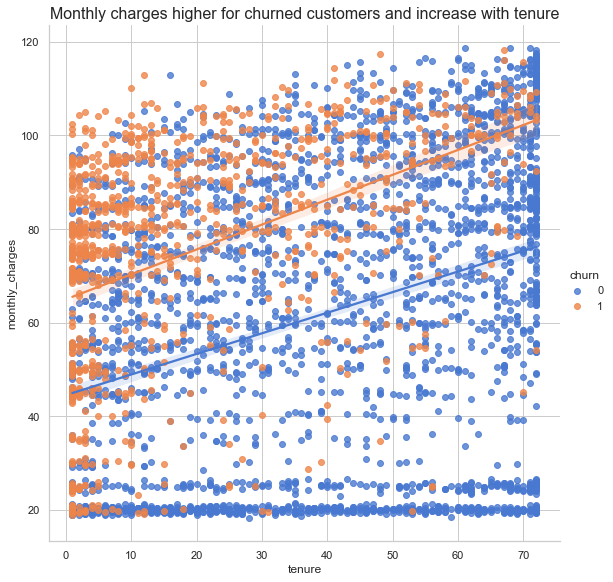

In [59]:
sns.lmplot(x = 'tenure', y= 'monthly_charges', hue='churn', data=train, size = 8)
plt.title('Monthly charges higher for churned customers and increase with tenure', fontsize= 16)
plt.show()

*This visualization does a good job showcasing how monthly charges go up with tenure, as well as the higher monthly charges for customesrs who churned.*

**New Related Question: What is the average tenure for those who churn? In other words, at what month do most customers usually churn?**

In [60]:
# Calculating average tenure at churn
churned.tenure.mean()

18.325047801147228

In [61]:
churned.tenure.describe()

count    1046.000000
mean       18.325048
std        19.960763
min         1.000000
25%         2.000000
50%        10.000000
75%        31.000000
max        72.000000
Name: tenure, dtype: float64

Text(0.5, 1.0, 'Distribution of tenure for churned customers')

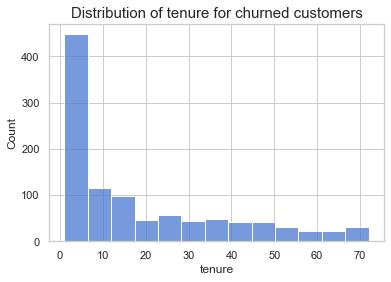

In [62]:
sns.histplot(data=churned, x='tenure')
plt.title('Distribution of tenure for churned customers', fontsize= 15)

Text(0.5, 1.0, 'Distribution of tenure')

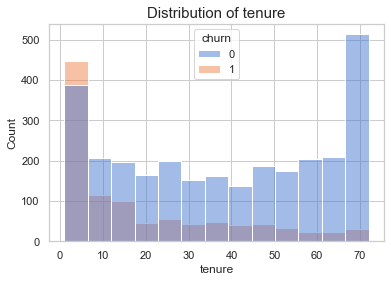

In [63]:
sns.histplot(data=train, x='tenure', hue= 'churn')
plt.title('Distribution of tenure', fontsize='15')

*While the average tenure at churn is around 18 months, these visualizations show most customers are churning around before the 10 month mark.*

# Modeling #

In [64]:
# Calculate the baseline for train data set

baseline = (train.churn == 1).mean()
print(f'Our baseline accuracy is {baseline}. We can compare our model accuracy to this figure.')

Our baseline accuracy is 0.2656845313690627. We can compare our model accuracy to this figure.


*This means if our model were to predict the all customers churned it would be aprroximately %27 accurate. This is the number our model needs to beat.*

## Models Using All Features ##

**Decision Trees**

In [65]:
#Model 1

clf1 = DecisionTreeClassifier(random_state=123)

clf1 = clf1.fit(X_train, y_train)

In [66]:
# Creating predictions and evaluating 

X = X_train
y = y_train

accuracy1 = clf1.score(X, y)
y_pred = clf1.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy1:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.998
The True Positive Rate is 0.992, The False Positive Rate is 0.0,
The True Negative Rate is 1.0, and the False Negative Rate is 0.00765



precision    recall  f1-score      support
0              0.997240  1.000000  0.998618  2891.000000
1              1.000000  0.992352  0.996161  1046.000000
accuracy       0.997968  0.997968  0.997968     0.997968
macro avg      0.998620  0.996176  0.997390  3937.000000
weighted avg   0.997974  0.997968  0.997965  3937.000000

In [67]:
#Turn our confusion matrix into a dataframe
conf_train = pd.DataFrame(conf, columns=['predict_churn', 'predict_retention'], index=['actual_churn', 'actual_retention'])
conf_train

predict_churn  predict_retention
actual_churn               2891                  0
actual_retention              8               1038

In [68]:
# Create a copy dataframe with predictions added as a column
train_predictions = train.copy()
train_predictions['predictions'] = y_pred
train_predictions.head()

customer_id  senior_citizen  partner  dependents  tenure  phone_service  \
5919  8331-ZXFOE               0        0           0      58              1   
1915  2790-XUYMV               0        0           1      71              1   
5054  7107-UBYKY               0        1           1      35              1   
2355  3373-YZZYM               0        1           1       1              1   
6279  8883-GRDWQ               1        0           0      20              1   

      multiple_lines  online_security  online_backup  device_protection  ...  \
5919               1                1              1                  1  ...   
1915               1                1              1                  0  ...   
5054               1                0              0                  0  ...   
2355               0                0              0                  0  ...   
6279               0                1              0                  0  ...   

      one_yr_contract  two_yr_contract  auto_bank_transfer  auto_credit_card  \
5919                1                0                   0                 1   
1915                1                0                   0                 1   
5054                0                0                   0                 0   
2355                0                0                   0                 0   
6279                1                0                   0                 0   

      electronic_check  mailed_check  dsl  fiber_optic  no_internet  \
5919                 0             0    1            0            0   
1915                 0             0    0            1            0   
5054                 1             0    0            0            1   
2355                 0             1    0            0            1   
6279                 0             1    1            0            0   

      predictions  
5919            0  
1915            0  
5054            0  
2355            0  
6279            0  

[5 rows x 30 columns]

In [69]:
# Sanity check
train_predictions[['churn', 'predictions']].head()

churn  predictions
5919      0            0
1915      0            0
5054      0            0
2355      0            0
6279      0            0

*Model with lower max depth to avoid overfitting*

In [70]:
#Model 2

clf2 = DecisionTreeClassifier(max_depth=3, random_state=123)

clf2 = clf2.fit(X_train, y_train)

In [71]:
# Creating predictions and evaluating 

X = X_train
y = y_train

accuracy2 = clf2.score(X, y)
y_pred = clf2.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy2:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.7981
The True Positive Rate is 0.401, The False Positive Rate is 0.0581,
The True Negative Rate is 0.942, and the False Negative Rate is 0.599



precision    recall  f1-score     support
0              0.812836  0.941889  0.872617  2891.00000
1              0.713799  0.400574  0.513166  1046.00000
accuracy       0.798070  0.798070  0.798070     0.79807
macro avg      0.763317  0.671231  0.692891  3937.00000
weighted avg   0.786523  0.798070  0.777116  3937.00000

**K-Nearest Neighor Model**

In [72]:
# Model 3

knn1 = KNeighborsClassifier()
knn1 = knn1.fit(X_train, y_train)

In [73]:
# Creating predictions and evaluating 

X = X_train
y = y_train

accuracy3 = knn1.score(X, y)
y_pred = knn1.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy3:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8313
The True Positive Rate is 0.58, The False Positive Rate is 0.0778,
The True Negative Rate is 0.922, and the False Negative Rate is 0.42



precision    recall  f1-score      support
0              0.858615  0.922172  0.889260  2891.000000
1              0.729567  0.580306  0.646432  1046.000000
accuracy       0.831344  0.831344  0.831344     0.831344
macro avg      0.794091  0.751239  0.767846  3937.000000
weighted avg   0.824329  0.831344  0.824744  3937.000000

*Model with lower K value to reduce overfitting*

In [74]:
#Model 4
# Create and fit K-Nearest Neighbor model *Default is 5

knn2 = KNeighborsClassifier(n_neighbors = 3)
knn2 = knn2.fit(X_train, y_train)

In [75]:
# Creating predictions and evaluating 

X = X_train
y = y_train

accuracy4 = knn2.score(X, y)
y_pred = knn2.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy4:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8595
The True Positive Rate is 0.662, The False Positive Rate is 0.0688,
The True Negative Rate is 0.931, and the False Negative Rate is 0.338



precision    recall  f1-score      support
0              0.883782  0.931166  0.906855  2891.000000
1              0.776655  0.661568  0.714507  1046.000000
accuracy       0.859538  0.859538  0.859538     0.859538
macro avg      0.830219  0.796367  0.810681  3937.000000
weighted avg   0.855320  0.859538  0.855751  3937.000000

*Model with higher K value*

In [76]:
#Model 5
# Create and fit K-Nearest Neighbor model 

knn3 = KNeighborsClassifier(n_neighbors = 10)
knn3 = knn3.fit(X_train, y_train)

In [77]:
# Creating predictions and evaluating 

X = X_train
y = y_train

accuracy5 = knn3.score(X, y)
y_pred = knn3.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy5:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8092
The True Positive Rate is 0.41, The False Positive Rate is 0.0464,
The True Negative Rate is 0.954, and the False Negative Rate is 0.59



precision    recall  f1-score      support
0              0.817131  0.953649  0.880128  2891.000000
1              0.761989  0.410134  0.533250  1046.000000
accuracy       0.809246  0.809246  0.809246     0.809246
macro avg      0.789560  0.681892  0.706689  3937.000000
weighted avg   0.802481  0.809246  0.787968  3937.000000

**Logistic Regression Models**

In [78]:
# Model 6
# Create our logistic regression model 

logit1 = LogisticRegression(random_state=123)
logit1 = logit1.fit(X_train, y_train)

In [79]:
# Creating predictions and evaluating 

X = X_train
y = y_train

accuracy6 = logit1.score(X, y)
y_pred = logit1.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy6:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8026
The True Positive Rate is 0.547, The False Positive Rate is 0.105,
The True Negative Rate is 0.895, and the False Negative Rate is 0.453



precision    recall  f1-score      support
0              0.845199  0.895192  0.869478  2891.000000
1              0.653714  0.546845  0.595523  1046.000000
accuracy       0.802642  0.802642  0.802642     0.802642
macro avg      0.749457  0.721019  0.732500  3937.000000
weighted avg   0.794325  0.802642  0.796692  3937.000000

*Model with class_weight balanced*

In [80]:
# Model 7
# Create logistic regression model

logit2 = LogisticRegression(random_state=123, class_weight='balanced')
logit2 = logit2.fit(X_train, y_train)

In [81]:
# Creating predictions and evaluating 

X = X_train
y = y_train

accuracy7 = logit2.score(X, y)
y_pred = logit2.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy7:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.7546
The True Positive Rate is 0.805, The False Positive Rate is 0.264,
The True Negative Rate is 0.736, and the False Negative Rate is 0.195



precision    recall  f1-score      support
0              0.912559  0.736423  0.815084  2891.000000
1              0.524938  0.804971  0.635472  1046.000000
accuracy       0.754636  0.754636  0.754636     0.754636
macro avg      0.718748  0.770697  0.725278  3937.000000
weighted avg   0.809574  0.754636  0.767364  3937.000000

## Models Using Top 5 Features ##

**Random Forest Models**

In [82]:
# Model 8
# Create and fit Random Forest Model

top_5_features=['electronic_check', 'monthly_contract', 'fiber_optic', 'monthly_charges', 'paperless_billing']

rf1 = RandomForestClassifier(min_samples_leaf=1, max_depth=10, random_state=123)
rf1 = rf1.fit(X_train[top_5_features], y_train)

In [83]:
# Creating predictions and evaluating 

X = X_train[top_5_features]
y = y_train

accuracy8 = rf1.score(X, y)
y_pred = rf1.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy8:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8593
The True Positive Rate is 0.676, The False Positive Rate is 0.0744,
The True Negative Rate is 0.926, and the False Negative Rate is 0.324



precision    recall  f1-score      support
0              0.887562  0.925631  0.906197  2891.000000
1              0.766811  0.675908  0.718496  1046.000000
accuracy       0.859284  0.859284  0.859284     0.859284
macro avg      0.827187  0.800770  0.812347  3937.000000
weighted avg   0.855481  0.859284  0.856328  3937.000000

*Try a model with different paramaters*

In [84]:
# Model 9
# Create and fit Random Forest Model

rf2 = RandomForestClassifier(min_samples_leaf=2, max_depth=15, random_state=123)
rf2 = rf2.fit(X_train[top_5_features], y_train)

In [85]:
# Creating predictions and evaluating 

X = X_train[top_5_features]
y = y_train

accuracy9 = rf2.score(X, y)
y_pred = rf2.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy9:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8738
The True Positive Rate is 0.702, The False Positive Rate is 0.064,
The True Negative Rate is 0.936, and the False Negative Rate is 0.298



precision    recall  f1-score      support
0              0.896620  0.936008  0.915891  2891.000000
1              0.798694  0.701721  0.747074  1046.000000
accuracy       0.873762  0.873762  0.873762     0.873762
macro avg      0.847657  0.818865  0.831482  3937.000000
weighted avg   0.870603  0.873762  0.871039  3937.000000

**KNN Models**

In [86]:
# Model 10
# Create and fit K-Nearest Neighbor model 

knn3 = KNeighborsClassifier()
knn3 = knn3.fit(X_train[top_5_features], y_train)

In [87]:
# Creating predictions and evaluating 

X = X_train[top_5_features]
y = y_train

accuracy10 = knn3.score(X, y)
y_pred = knn3.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy10:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8245
The True Positive Rate is 0.601, The False Positive Rate is 0.0948,
The True Negative Rate is 0.905, and the False Negative Rate is 0.399



precision    recall  f1-score      support
0              0.862558  0.905223  0.883376  2891.000000
1              0.696567  0.601338  0.645459  1046.000000
accuracy       0.824486  0.824486  0.824486     0.824486
macro avg      0.779562  0.753281  0.764417  3937.000000
weighted avg   0.818457  0.824486  0.820165  3937.000000

*Try one with lower K value*

In [88]:
# Model 11
# Create and fit K-Nearest Neighbor model 

knn4 = KNeighborsClassifier(n_neighbors=3)
knn4 = knn4.fit(X_train[top_5_features], y_train)

In [89]:
# Creating predictions and evaluating 

X = X_train[top_5_features]
y = y_train

accuracy11 = knn4.score(X, y)
y_pred = knn4.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy11:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8489
The True Positive Rate is 0.661, The False Positive Rate is 0.083,
The True Negative Rate is 0.917, and the False Negative Rate is 0.339



precision    recall  f1-score     support
0              0.881903  0.916984  0.899101  2891.00000
1              0.742213  0.660612  0.699039  1046.00000
accuracy       0.848870  0.848870  0.848870     0.84887
macro avg      0.812058  0.788798  0.799070  3937.00000
weighted avg   0.844789  0.848870  0.845948  3937.00000

**Logistic Regression Models**

In [90]:
# Model 12
#Create logistic regresssion model

logit3 = LogisticRegression(random_state=123)
logit3 = logit3.fit(X_validate[top_5_features], y_validate)

In [91]:

X = X_validate[top_5_features]
y = y_validate

accuracy12 = logit3.score(X, y)
y_pred = logit3.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy12:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.7666
The True Positive Rate is 0.352, The False Positive Rate is 0.0831,
The True Negative Rate is 0.917, and the False Negative Rate is 0.648



precision    recall  f1-score      support
0              0.796076  0.916868  0.852213  1239.000000
1              0.605364  0.351893  0.445070   449.000000
accuracy       0.766588  0.766588  0.766588     0.766588
macro avg      0.700720  0.634381  0.648642  1688.000000
weighted avg   0.745347  0.766588  0.743915  1688.000000

## Models Using Top 2 Features ##

**Decision Trees**

In [92]:
# Model 13
#Create and fit our model

top_2_features = ['monthly_contract', 'fiber_optic']

clf3 = DecisionTreeClassifier(random_state=123)

clf3 = clf3.fit(X_train[top_2_features], y_train)

In [93]:
# Creating predictions and evaluating 

X = X_train[top_2_features]
y = y_train

accuracy13 = clf3.score(X, y)
y_pred = clf3.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy13:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.7724
The True Positive Rate is 0.629, The False Positive Rate is 0.176,
The True Negative Rate is 0.824, and the False Negative Rate is 0.371



precision    recall  f1-score      support
0              0.859978  0.824282  0.841752  2891.000000
1              0.564322  0.629063  0.594937  1046.000000
accuracy       0.772416  0.772416  0.772416     0.772416
macro avg      0.712150  0.726673  0.718344  3937.000000
weighted avg   0.781427  0.772416  0.776177  3937.000000

**KNN Model**

In [94]:
# Model 14
# Create and fit K-Nearest Neighbor model 

knn5 = KNeighborsClassifier(n_neighbors=3)
knn5 = knn5.fit(X_train[top_2_features], y_train)

In [95]:
# Creating predictions and evaluating 

X = X_train[top_2_features]
y = y_train

accuracy14 = knn5.score(X, y)
y_pred = knn5.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy14:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.7724
The True Positive Rate is 0.629, The False Positive Rate is 0.176,
The True Negative Rate is 0.824, and the False Negative Rate is 0.371



precision    recall  f1-score      support
0              0.859978  0.824282  0.841752  2891.000000
1              0.564322  0.629063  0.594937  1046.000000
accuracy       0.772416  0.772416  0.772416     0.772416
macro avg      0.712150  0.726673  0.718344  3937.000000
weighted avg   0.781427  0.772416  0.776177  3937.000000

**Compare all my Models Scores to decide which to use on evaluate and the test**

In [96]:
print(f'''Model 1: {accuracy1}''')
print(f'''Model 2: {accuracy2}''')
print(f'''Model 3: {accuracy3}''')
print(f'''Model 4: {accuracy4}''')
print(f'''Model 5: {accuracy5}''')
print(f'''Model 6: {accuracy6}''')
print(f'''Model 7: {accuracy7}''')
print(f'''Model 8: {accuracy8}''')
print(f'''Model 9: {accuracy9}''')
print(f'''Model 10: {accuracy10}''')
print(f'''Model 11: {accuracy11}''')
print(f'''Model 12: {accuracy12}''')
print(f'''Model 13: {accuracy13}''')
print(f'''Model 14: {accuracy14}''')

Model 1: 0.9979679959359918
Model 2: 0.7980695961391923
Model 3: 0.8313436626873254
Model 4: 0.8595377190754382
Model 5: 0.809245618491237
Model 6: 0.8026416052832106
Model 7: 0.7546355092710185
Model 8: 0.8592837185674371
Model 9: 0.873761747523495
Model 10: 0.824485648971298
Model 11: 0.8488696977393955
Model 12: 0.7665876777251185
Model 13: 0.7724155448310897
Model 14: 0.7724155448310897


*I'll fit my top 5 models to validate and select the best 3 from those.
Top 5 : Model 1, Model 9, Model 8, Model 4, Model 11*

In [97]:
#Model 1 Validate

clf1 = DecisionTreeClassifier(random_state=123)

clf1 = clf1.fit(X_validate, y_validate)

In [98]:
# Creating predictions and evaluating 

X = X_validate
y = y_validate

accuracy1 = clf1.score(X, y)
y_pred = clf1.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy1:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.9994
The True Positive Rate is 0.998, The False Positive Rate is 0.0,
The True Negative Rate is 1.0, and the False Negative Rate is 0.00223



precision    recall  f1-score      support
0              0.999194  1.000000  0.999597  1239.000000
1              1.000000  0.997773  0.998885   449.000000
accuracy       0.999408  0.999408  0.999408     0.999408
macro avg      0.999597  0.998886  0.999241  1688.000000
weighted avg   0.999408  0.999408  0.999407  1688.000000

In [99]:
#Model 4 Validate
# Create and fit K-Nearest Neighbor model *Default is 5

knn2 = KNeighborsClassifier(n_neighbors = 3)
knn2 = knn2.fit(X_validate, y_validate)

In [100]:
# Creating predictions and evaluating 

X = X_validate
y = y_validate

accuracy4 = knn2.score(X, y)
y_pred = knn2.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy4:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8549
The True Positive Rate is 0.628, The False Positive Rate is 0.063,
The True Negative Rate is 0.937, and the False Negative Rate is 0.372



precision    recall  f1-score      support
0              0.874247  0.937046  0.904558  1239.000000
1              0.783333  0.628062  0.697157   449.000000
accuracy       0.854858  0.854858  0.854858     0.854858
macro avg      0.828790  0.782554  0.800857  1688.000000
weighted avg   0.850064  0.854858  0.849390  1688.000000

In [101]:
# Model 8 Validate
# Create and fit Random Forest Model

top_5_features=['electronic_check', 'monthly_contract', 'fiber_optic', 'monthly_charges', 'paperless_billing']

rf1 = RandomForestClassifier(min_samples_leaf=1, max_depth=10, random_state=123)
rf1 = rf1.fit(X_validate[top_5_features], y_validate)

In [102]:
# Creating predictions and evaluating 

X = X_validate[top_5_features]
y = y_validate

accuracy8 = rf1.score(X, y)
y_pred = rf1.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy8:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.904
The True Positive Rate is 0.733, The False Positive Rate is 0.0339,
The True Negative Rate is 0.966, and the False Negative Rate is 0.267



precision    recall  f1-score      support
0              0.908884  0.966102  0.936620  1239.000000
1              0.886792  0.732739  0.802439   449.000000
accuracy       0.904028  0.904028  0.904028     0.904028
macro avg      0.897838  0.849421  0.869529  1688.000000
weighted avg   0.903008  0.904028  0.900928  1688.000000

In [103]:
# Model 9 Validate
# Create and fit Random Forest Model

rf2 = RandomForestClassifier(min_samples_leaf=2, max_depth=15, random_state=123)
rf2 = rf2.fit(X_validate[top_5_features], y_validate)

In [104]:
# Creating predictions and evaluating 

X = X_validate[top_5_features]
y = y_validate

accuracy9 = rf2.score(X, y)
y_pred = rf2.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy9:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8809
The True Positive Rate is 0.699, The False Positive Rate is 0.0533,
The True Negative Rate is 0.947, and the False Negative Rate is 0.301



precision    recall  f1-score      support
0              0.896789  0.946731  0.921084  1239.000000
1              0.826316  0.699332  0.757539   449.000000
accuracy       0.880924  0.880924  0.880924     0.880924
macro avg      0.861552  0.823032  0.839311  1688.000000
weighted avg   0.878043  0.880924  0.877582  1688.000000

In [105]:
# Model 11 Validate
# Create and fit K-Nearest Neighbor model 

knn4 = KNeighborsClassifier(n_neighbors=3)
knn4 = knn4.fit(X_validate[top_5_features], y_validate)

In [106]:
# Creating predictions and evaluating 

X = X_validate[top_5_features]
y = y_validate

accuracy11 = knn4.score(X, y)
y_pred = knn4.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy11:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8549
The True Positive Rate is 0.657, The False Positive Rate is 0.0734,
The True Negative Rate is 0.927, and the False Negative Rate is 0.343



precision    recall  f1-score      support
0              0.881720  0.926554  0.903581  1239.000000
1              0.764249  0.657016  0.706587   449.000000
accuracy       0.854858  0.854858  0.854858     0.854858
macro avg      0.822985  0.791785  0.805084  1688.000000
weighted avg   0.850474  0.854858  0.851182  1688.000000

*What are my top 3 scores when fit to the validate data set?*

In [107]:
print(f'''Model 1: {accuracy1}''')
print(f'''Model 4: {accuracy4}''')
print(f'''Model 8: {accuracy8}''')
print(f'''Model 9: {accuracy9}''')
print(f'''Model 11: {accuracy11}''')

Model 1: 0.9994075829383886
Model 4: 0.8548578199052133
Model 8: 0.9040284360189573
Model 9: 0.8809241706161137
Model 11: 0.8548578199052133


*Top 3: Model 1, Model 8, Model 9*

## Evaluate on Test ##

In [108]:
#Model 1 Test

clf1 = DecisionTreeClassifier(random_state=123)

clf1 = clf1.fit(X_test, y_test)

In [109]:
# Creating predictions and evaluating 

X = X_test
y = y_test

accuracy1 = clf1.score(X, y)
y_pred1 = clf1.predict(X)
conf = confusion_matrix(y, y_pred1)
class_report = pd.DataFrame(classification_report(y, y_pred1, output_dict=True)).T
conf = confusion_matrix(y, y_pred1)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy1:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 1.0
The True Positive Rate is 1.0, The False Positive Rate is 0.0,
The True Negative Rate is 1.0, and the False Negative Rate is 0.0



precision  recall  f1-score  support
0                   1.0     1.0       1.0   1033.0
1                   1.0     1.0       1.0    374.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   1407.0
weighted avg        1.0     1.0       1.0   1407.0

In [110]:
# Model 8 Test
# Create and fit Random Forest Model

top_5_features=['electronic_check', 'monthly_contract', 'fiber_optic', 'monthly_charges', 'paperless_billing']

rf1 = RandomForestClassifier(min_samples_leaf=1, max_depth=10, random_state=123)
rf1 = rf1.fit(X_test[top_5_features], y_test)

In [111]:
# Creating predictions and evaluating 

X = X_test[top_5_features]
y = y_test

accuracy8 = rf1.score(X, y)
y_pred2 = rf1.predict(X)
conf = confusion_matrix(y, y_pred2)
class_report = pd.DataFrame(classification_report(y, y_pred2, output_dict=True)).T
conf = confusion_matrix(y, y_pred2)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy8:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.9204
The True Positive Rate is 0.84, The False Positive Rate is 0.0503,
The True Negative Rate is 0.95, and the False Negative Rate is 0.16



precision    recall  f1-score      support
0              0.942363  0.949661  0.945998  1033.000000
1              0.857923  0.839572  0.848649   374.000000
accuracy       0.920398  0.920398  0.920398     0.920398
macro avg      0.900143  0.894617  0.897323  1407.000000
weighted avg   0.919918  0.920398  0.920121  1407.000000

In [112]:
# Model 9 Test
# Create and fit Random Forest Model

rf2 = RandomForestClassifier(min_samples_leaf=2, max_depth=15, random_state=123)
rf2 = rf2.fit(X_test[top_5_features], y_test)

In [113]:
# Creating predictions and evaluating 

X = X_test[top_5_features]
y = y_test

accuracy9 = rf2.score(X, y)
y_pred3 = rf2.predict(X)
conf = confusion_matrix(y, y_pred3)
class_report = pd.DataFrame(classification_report(y, y_pred3, output_dict=True)).T
conf = confusion_matrix(y, y_pred3)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy9:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8955
The True Positive Rate is 0.727, The False Positive Rate is 0.0436,
The True Negative Rate is 0.956, and the False Negative Rate is 0.273



precision    recall  f1-score      support
0              0.906422  0.956438  0.930758  1033.000000
1              0.858044  0.727273  0.787265   374.000000
accuracy       0.895522  0.895522  0.895522     0.895522
macro avg      0.882233  0.841855  0.859012  1407.000000
weighted avg   0.893563  0.895522  0.892616  1407.000000

In [114]:
test_predictions = test.copy()
test_predictions['predictions'] = y_pred2
train_predictions.head()

customer_id  senior_citizen  partner  dependents  tenure  phone_service  \
5919  8331-ZXFOE               0        0           0      58              1   
1915  2790-XUYMV               0        0           1      71              1   
5054  7107-UBYKY               0        1           1      35              1   
2355  3373-YZZYM               0        1           1       1              1   
6279  8883-GRDWQ               1        0           0      20              1   

      multiple_lines  online_security  online_backup  device_protection  ...  \
5919               1                1              1                  1  ...   
1915               1                1              1                  0  ...   
5054               1                0              0                  0  ...   
2355               0                0              0                  0  ...   
6279               0                1              0                  0  ...   

      one_yr_contract  two_yr_contract  auto_bank_transfer  auto_credit_card  \
5919                1                0                   0                 1   
1915                1                0                   0                 1   
5054                0                0                   0                 0   
2355                0                0                   0                 0   
6279                1                0                   0                 0   

      electronic_check  mailed_check  dsl  fiber_optic  no_internet  \
5919                 0             0    1            0            0   
1915                 0             0    0            1            0   
5054                 1             0    0            0            1   
2355                 0             1    0            0            1   
6279                 0             1    1            0            0   

      predictions  
5919            0  
1915            0  
5054            0  
2355            0  
6279            0  

[5 rows x 30 columns]

In [115]:
# Sanity check
predictions = test_predictions[['customer_id', 'churn', 'predictions']]
predictions = predictions.rename(columns={'churn': 'actual_churn'})
predictions

customer_id  actual_churn  predictions
3311  4716-MRVEN             0            0
6330  8966-KZXXA             0            0
6156  8720-RQSBJ             0            0
5313  7504-UWHNB             0            0
1176  1730-VFMWO             0            0
...          ...           ...          ...
600   0877-SDMBN             1            0
3946  5555-RNPGT             0            0
3230  4628-CTTLA             1            1
349   0516-QREYC             0            0
3690  5198-HQAEN             0            0

[1407 rows x 3 columns]

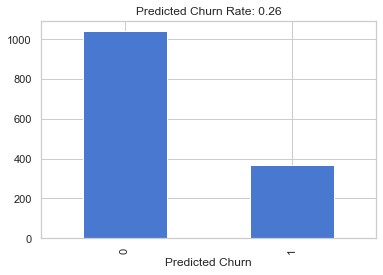

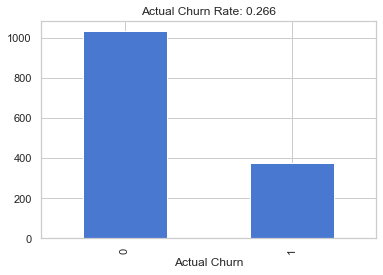

In [116]:
predictions.predictions.value_counts().sort_index().plot.bar()
predicted_churn_rate = predictions.predictions.mean()
plt.title(f'Predicted Churn Rate: {predicted_churn_rate:.3}')
plt.xlabel('Predicted Churn')
plt.show()

predictions.actual_churn.value_counts().sort_index().plot.bar()
actual_churn_rate = predictions.actual_churn.mean()
plt.title(f'Actual Churn Rate: {actual_churn_rate:.3}')
plt.xlabel('Actual Churn')
plt.show()